In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as tx

from PIL import Image
from skimage.io import imread, imshow

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from skimage.color import rgba2rgb
from skimage.color import rgb2gray

class KaggleDataset(Dataset):
    """Kaggle dataset."""

    def __init__(self, root, transform=None):
        """
        Args:
            root_dir (string): Directory of data (train or test).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root
        self.transform = transform
        self.ids = next(os.walk(root))[1]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.ids[idx], 'images', self.ids[idx] + '.png')
        image = Image.open(img_name)
        # overlay masks to single mask
        w, h = image.size
        label = np.zeros((h, w), dtype=np.uint8) 
        mask_dir = os.path.join(self.root, self.ids[idx], 'masks')
        if os.path.isdir(mask_dir):
            for fn in next(os.walk(mask_dir))[2]:
                fp = os.path.join(mask_dir, fn)
                m = imread(fp, flatten=True, mode='L') 

                label[m>0] = 255  # change the 1-bit b&w to gray scale

                #label = np.maximum(label, m) # merge mask
        label = Image.fromarray(label, 'L') # specify it's grayscale 8-bit
        #label = Image.fromarray(label, '1') # specify it's 1-bit b&w image
        #label = label.convert('1') # convert to 1-bit pixels, black and white 
        sample = {'image': image, 'label': label, 'name':img_name}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
train = KaggleDataset('data/stage1_train')
print(" Dataset {0:4d} loaded".format(len(train.ids)))

 Dataset  668 loaded


 Sample: data/stage1_train/7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2/images/7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2.png shape: (256, 256) (256, 256)
sample: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256 at 0x7F19F6FA3C18>
label: <PIL.Image.Image image mode=L size=256x256 at 0x7F196ED91860>


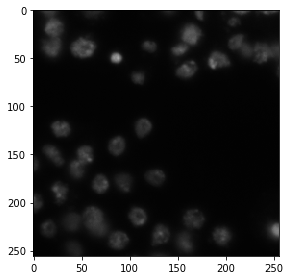

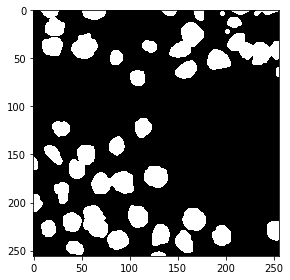

In [4]:
for sample in train:
    print(" Sample: {0} shape: {1} {2}".format(sample['name'], sample['image'].size , sample['label'].size))
    print("sample:",sample['image'] )
    print("label:", sample['label'])
    imshow(np.asarray(sample['image']))
    plt.show()
    imshow(np.asarray(sample['label'])) 
    plt.show()
    break

In [6]:
composed = transforms.Compose([
    transforms.RandomResizedCrop(128), # 128x128
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0,5, 0.5],
    #                     std=[0.5, 0.5, 0.5]),
])

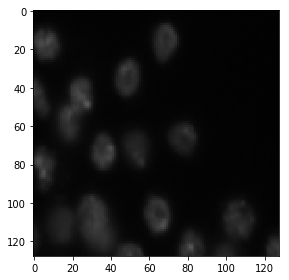

In [7]:
for sample in train:
    img = sample['image']
    #img.size
    transformed_sample = composed(img)
    imshow(np.asarray(transformed_sample))
    plt.show()
    break

We would like to keep source and target images aligned, in order to keep pixel label correct. Thus we need functional interface of transform classes as below.

In [8]:
MEAN = [0.5, 0.5, 0.5, 0.5]
STD  = [0.5, 0.5, 0.5, 0.5]

class Compose():
    def __init__(self, size, mean=MEAN, std=STD, tensor=True, binary=True):
        self.size = (size, size)
        self.mean = mean
        self.std = std
        self.toTensor = tensor
        self.toBinary = binary

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # perform RandomResizedCrop(), use default parameter
        i, j, h, w = transforms.RandomResizedCrop.get_params(image, 
                                                             scale=(0.08, 1.0), 
                                                             ratio=(3. / 4., 4. / 3.))
        image = tx.resized_crop(image, i, j, h, w, self.size)
        label = tx.resized_crop(label, i, j, h, w, self.size)
        
        # perform RandomHorizontalFlip()
        if random.random() > 0.5:
            image = tx.hflip(image)
            label = tx.hflip(label)

        # Due to resize algorithm may introduce anti-alias edge, aka. non binary value, 
        # thereafter map every pixel back to 0 and 255
        if self.toBinary:
            label = label.point(lambda p, threhold=100: 255 if p > threhold else 0)             

        # perform ToTensor()
        if self.toTensor:
            image = tx.to_tensor(image)
            label = tx.to_tensor(label)
        
        # perform Normalize()
        if self.toTensor:
            image = tx.normalize(image, self.mean, self.std)
        
        return {'image': image, 'label': label}

In [9]:
def deNormalize(tensor, mean=MEAN, std=STD):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def toPilImage(tensor):
    return tx.to_pil_image(tensor)

def showSample(image, label):
    image = deNormalize(image)
    image = toPilImage(image)
    image = np.asarray(image)
    imshow(image)
    plt.show()
    
    label = toPilImage(label)
    label = np.asarray(label)
    imshow(label)
    plt.show()


In [10]:
train = KaggleDataset('data/stage1_train', transform=Compose(128))

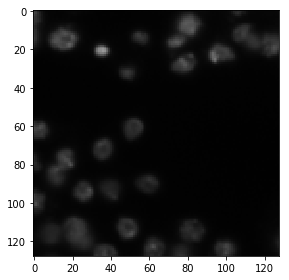

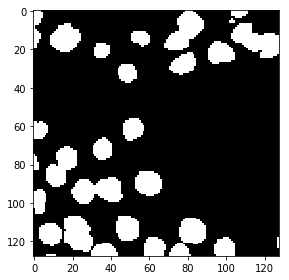

In [11]:
for sample in train:
    showSample(sample['image'], sample['label'])
    break

Let validate testing set can be loaded without transformation, be aware of no ground true label for testing set

In [12]:
test = KaggleDataset('data/stage1_test')

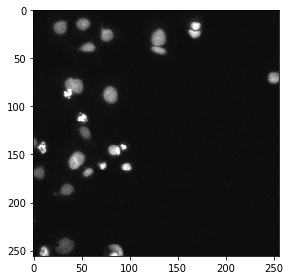

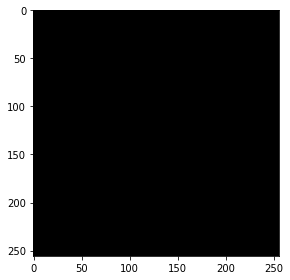

In [13]:
for sample in test:
    imshow(np.asarray(sample['image']))
    plt.show()
    imshow(np.asarray(sample['label']))
    plt.show()
    break

It's time to define neural network

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, dropout_rate=0.1, activation=F.relu):
        super().__init__()
        self.conv1 = nn.Conv2d(in_size,  out_size, kernel_size, padding=1)
        #self.norm1 = nn.BatchNorm2d(out_size)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size, padding=1)
        #self.norm2 = nn.BatchNorm2d(out_size)
        self.activation = activation
        self.drop = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        #x = self.norm1(x)
        x = self.drop(x)
        x = self.activation(self.conv2(x))
        #x = self.norm2(x)
        return x

class ConvUpBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, dropout_rate=0.1, activation=F.relu):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, 2, stride=2)
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size, padding=1)
        #self.norm1 = nn.BatchNorm2d(out_size)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size, padding=1)
        #self.norm2 = nn.BatchNorm2d(out_size)
        self.activation = activation
        self.drop = nn.Dropout2d(p=dropout_rate)

    def forward(self, x, bridge):
        x = self.up(x)
        x = torch.cat([x, bridge], 1)
        x = self.activation(self.conv1(x))
        #x = self.norm1(x)
        x = self.drop(x)
        x = self.activation(self.conv2(x))
        #x = self.norm2(x)
        return x
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = ConvBlock(4, 16)
        self.p1 = nn.MaxPool2d(2)
        self.c2 = ConvBlock(16, 32)
        self.p2 = nn.MaxPool2d(2)
        self.c3 = ConvBlock(32, 64)
        self.p3 = nn.MaxPool2d(2)
        self.c4 = ConvBlock(64, 128)
        self.p4 = nn.MaxPool2d(2)
        self.c5 = ConvBlock(128, 256)
        self.u6 = ConvUpBlock(256, 128)
        self.u7 = ConvUpBlock(128, 64)
        self.u8 = ConvUpBlock(64, 32)
        self.u9 = ConvUpBlock(32, 16)
        self.ce = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        c1 = x = self.c1(x)
        x = self.p1(x)
        c2 = x = self.c2(x)
        x = self.p2(x)
        c3 = x = self.c3(x)
        x = self.p3(x)
        c4 = x = self.c4(x)
        x = self.p4(x)
        c5 = x = self.c5(x)
        x = self.u6(x, c4)
        x = self.u7(x, c3)
        x = self.u8(x, c2)
        x = self.u9(x, c1)
        x = self.ce(x)
        x = F.sigmoid(x)
        return x

In [15]:
# configure hyperparameters
n_epoch = 10
n_batch = 10
n_train = 670
n_worker = 2
n_step = n_train // n_batch
learn_rate = 0.001
argument = True
cuda = True

In [16]:
net = Net()
if cuda:
    #net = net.cuda()
    net = torch.nn.DataParallel(net).cuda()
print(net)

DataParallel(
  (module): Net(
    (c1): ConvBlock(
      (conv1): Conv2d (4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d (16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop): Dropout2d(p=0.1)
    )
    (p1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (c2): ConvBlock(
      (conv1): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop): Dropout2d(p=0.1)
    )
    (p2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (c3): ConvBlock(
      (conv1): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop): Dropout2d(p=0.1)
    )
    (p3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (c4): ConvBlock(
      (conv1): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), 

In [17]:
cost = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learn_rate, weight_decay=1e-6)

In [18]:
train = KaggleDataset('data/stage1_train', transform=Compose(128))
dataloader = DataLoader(train, batch_size=n_batch, shuffle=True, num_workers=n_worker)

In [19]:
n_report = 10
for epoch in range(n_epoch):
    net.train() # Sets the module in training mode.
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs
        inputs = data['image']
        labels = data['label']
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        
        # debug network output
#         if cuda:
#             a = outputs.cpu().data.numpy()
#             b = labels.cpu().data.numpy()
#         else:
#             a = outputs.data.numpy()
#             b = labels.data.numpy()
#         print(a.size, np.count_nonzero( a ), np.sum( a < 0. ), np.sum( a > 1. ))
#         print(b.size, np.count_nonzero( b ), np.sum( b < 0. ), np.sum( b > 1. ))
        
        loss = cost(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]
        # print every num_step mini-batches
        if i % n_report == n_report - 1:
            print('[%d, %3d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / n_report))
            running_loss = 0.0
print('Finished Training')


[1,  10] loss: 0.572
[1,  20] loss: 0.390
[1,  30] loss: 0.374
[1,  40] loss: 0.334
[1,  50] loss: 0.358
[1,  60] loss: 0.374
[2,  10] loss: 0.301
[2,  20] loss: 0.288
[2,  30] loss: 0.310
[2,  40] loss: 0.306
[2,  50] loss: 0.269
[2,  60] loss: 0.300
[3,  10] loss: 0.219
[3,  20] loss: 0.227
[3,  30] loss: 0.256
[3,  40] loss: 0.257
[3,  50] loss: 0.221
[3,  60] loss: 0.247
[4,  10] loss: 0.209
[4,  20] loss: 0.201
[4,  30] loss: 0.206
[4,  40] loss: 0.228
[4,  50] loss: 0.265
[4,  60] loss: 0.206
[5,  10] loss: 0.197
[5,  20] loss: 0.204
[5,  30] loss: 0.247
[5,  40] loss: 0.220
[5,  50] loss: 0.221
[5,  60] loss: 0.233
[6,  10] loss: 0.201
[6,  20] loss: 0.194
[6,  30] loss: 0.186
[6,  40] loss: 0.218
[6,  50] loss: 0.216
[6,  60] loss: 0.199
[7,  10] loss: 0.221
[7,  20] loss: 0.203
[7,  30] loss: 0.186
[7,  40] loss: 0.165
[7,  50] loss: 0.196
[7,  60] loss: 0.227
[8,  10] loss: 0.206
[8,  20] loss: 0.203
[8,  30] loss: 0.192
[8,  40] loss: 0.224
[8,  50] loss: 0.212
[8,  60] loss

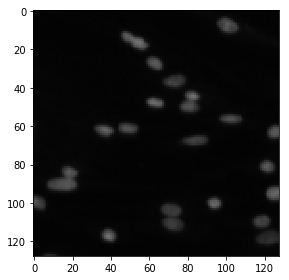

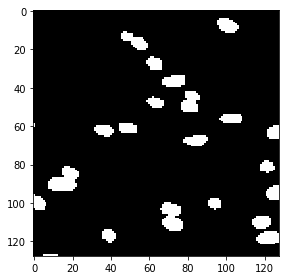

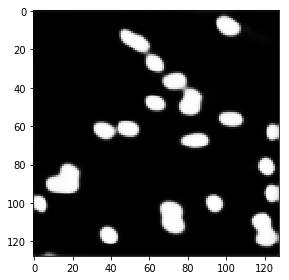

In [20]:
net.eval() # Sets the module in evaluation mode

for sample in train:
    # get first sample
    x = data['image'][0]
    yt = data['label'][0]
    showSample(x, yt)

    # get predict 
    x = x.unsqueeze(0)
    #print(type(x), x.shape)
    x = Variable(x)
    if cuda:
        x = x.cuda()
    y = net(x)
    if cuda:
        y = y.cpu()
    y = y.data.numpy()[0]
    y = np.transpose(y, (1, 2, 0))
    y = np.squeeze(y)
    #print(type(y), y.shape, y[0][0])
    imshow(y)
    plt.show()
    break


To split original data into train and cross-validate set, it could be done as below in ratio of 9:1

In [21]:
train = KaggleDataset('data/stage1_train', transform=Compose(128))
n_train = len(train)
valid_size = 0.1
indices = list(range(n_train))
split = int(np.floor(valid_size * n_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_loader = DataLoader(train, batch_size=n_batch, sampler=SubsetRandomSampler(train_idx), num_workers=n_worker)
valid_loader = DataLoader(train, batch_size=n_batch, sampler=SubsetRandomSampler(valid_idx), num_workers=n_worker)